# Puzzle Maker
This is a simple program that will take in an image and turn it into a puzzle.<br>
Some of my goals for this project are:<br>
- Customize the number of pieces of the final puzzle (with upper and lower limit)
- Start with square pieces then attempt to make them more like puzzle pieces (add curves, connectors, blanks, etc)
  - One option is to use pre-made templates and split accordingly but I prefer to randomize it

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt

plt.ioff()

# Let's try something

https://stackoverflow.com/questions/66499840/matplotlib-how-can-i-draw-a-circle-with-random-x-deformations

In [2]:
from PIL import Image, ImageDraw, ImageOps

filepath = "images/IMG_6554.jpg"
filename = "IMG_6554"

img = cv2.imread(filepath)
img = cv2.cvtColor(img, cv2.COLOR_BGR2BGRA)
h,w,_ = img.shape
img = img[:,:h]
h,w,_ = img.shape
resized_img = cv2.resize(img, (w*2, h*2))
h2,w2,_ = resized_img.shape

# img_arr = np.array(img)

print(h,w)
print(h2, w2)

1655 1655
3310 3310


In [ ]:
def deformed_circle(num_points, deform_angle, size=1):
    angle_step_size = 360 // num_points

    #Generate 50 evenly spaced theta values between 0-2pi (circle)
    theta = np.linspace(0, 2*np.pi)
    k = 0.6
    theta1 = deform_angle * np.pi / 180 #angle of deformation
    alpha = angle_step_size * np.pi / 180 #distance between points
    th = theta - theta1
    t = np.abs(np.where(th < np.pi, th, th - 2*np.pi)) / alpha
    r = np.where(t > 2, 1, k + (2*t**2-9*t+11)*t**2*(1-k)/4)
    
    fig, ax = plt.subplots()

    
    fig_size = size // 100
    #print(f"fig_size: {fig_size}")
    fig = plt.figure(frameon=False, figsize=(fig_size, fig_size))
    ax = plt.Axes(fig, [0.,0.,1.,1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    
    #plt.plot(np.cos(theta), np.sin(theta), ':r')
    ax.plot(r * np.cos(theta), r * np.sin(theta), color='white')
    ax.axis('equal')
    plt.fill(r * np.cos(theta), r * np.sin(theta), color='white')
    fig.canvas.draw()
    
    buf = fig.canvas.buffer_rgba()
    ncols, nrows = fig.canvas.get_width_height()
    print(ncols, nrows)
    print(size)
    image = np.frombuffer(buf, dtype=np.uint8).reshape((nrows, ncols, 4))
    # for i in range(-5, 5):
    #     ax.plot(radius*np.cos(theta1 + i * alpha), radius*np.sin(theta1 + i * alpha), 'xk')

    #plt.show()
    return image

In [ ]:
theta = np.linspace(0, 2 * np.pi)
k = 0.8
theta1 = -270 * np.pi / 180  # a deformation at theta 80 degrees
alpha = 36 * np.pi / 180  # have a special point every 36 degrees (10 on the circle)
th = theta - theta1  # the difference between the angles, still needs to be careful to make this difference symmetrical to zero
t = np.abs(np.where(th < np.pi, th, th - 2 * np.pi)) / alpha  # use absolute value and let alpha represent a step of 1
r = np.where(t > 2, 1, k + (2 * t ** 2 - 9 * t + 11) * t ** 2 * (1 - k) / 4) # the deformed radius

plt.plot(r * np.cos(theta), r * np.sin(theta), '-b')
plt.fill(r * np.cos(theta), r * np.sin(theta), color='blue', alpha=0.2)

plt.axis('equal')
plt.show()
plt.close('all')

In [ ]:
size = min(h,w)//10
np_circle = ~deformed_circle(10, 0, size)
np_circle_2 = ~deformed_circle(10, 180, size)
circle_mask = cv2.cvtColor(np_circle, cv2.COLOR_RGBA2GRAY)
circle_mask_2 = cv2.cvtColor(np_circle_2, cv2.COLOR_RGBA2GRAY)

#np.bitwise_or allows me to stack the masks and retain the datatype
mask = np.bitwise_or(np.roll(circle_mask, 50, axis=1), np.roll(circle_mask_2, -50, axis=1))
#display(Image.fromarray(mask))
#print(mask.dtype)
#print(circle_mask.shape)
#np.roll allows us to move the mask around
final_img_arr = np.dstack((img[:(size//100)*100,:(size//100)*100,:], np.roll(circle_mask, 0, axis=1)))
#img_mask = np.dstack((img_arr[:(size//100)*100,:(size//100)*100,:], mask))
# final_img_arr = section[np_circle]
#display(Image.fromarray(img_mask))
display(Image.fromarray(final_img_arr))
#cv2.imshow('masked image', final_img_arr)
#cv2.waitKey(0)

plt.close('all')


In [ ]:
#Example of merging masks and applying them on an image using cv2

size = min(h,w)//2
np_circle = ~deformed_circle(10, 0, size)
np_circle_2 = ~deformed_circle(10, 180, size)
circle_mask = cv2.cvtColor(np_circle, cv2.COLOR_RGBA2BGR)
circle_mask_2 = cv2.cvtColor(np_circle_2, cv2.COLOR_RGBA2BGR)


#np.bitwise_or allows me to stack the masks and retain the datatype
mask = np.bitwise_or(np.roll(circle_mask, 10, axis=1), np.roll(circle_mask_2, -10, axis=1))
mask_out = cv2.subtract(mask, img[:(size//100)*100,:(size//100)*100,:])
mask_out = cv2.subtract(mask, mask_out)
#display(Image.fromarray(mask))
#print(mask.dtype)
#print(circle_mask.shape)
#np.roll allows us to move the mask around
#final_img_arr = np.dstack((img[:(size//100)*100,:(size//100)*100,:], np.roll(circle_mask, 0, axis=1)))
#img_mask = np.dstack((img_arr[:(size//100)*100,:(size//100)*100,:], mask))
# final_img_arr = section[np_circle]
display(Image.fromarray(mask_out))
#cv2.imshow('masked', mask_out)
#cv2.imshow('masked image', final_img_arr)
#cv2.waitKey(0)

plt.close('all')

In [ ]:
segment = h//16
piece_h = 6*segment
#print(piece_h)
puzzle_piece = np.zeros((piece_h, piece_h, 4), dtype=np.uint8)
x_start = segment
x_end = piece_h - segment
y_start = segment
y_end = piece_h - segment
#puzzle_piece[x_start:x_end, y_start:y_end, :3] = img[:segment*4, :segment*4]
puzzle_piece[x_start:x_end, y_start:y_end] = 255
#display(Image.fromarray(puzzle_piece))

shift = segment // 8

tab_top = deformed_circle(10, 100, segment)
#padded_image = np.pad(image, ((top, bottom), (left, right)), mode='constant')
tab_top = np.pad(tab_top, ((3+shift,5*segment-shift), (3+3*segment,2*segment), (0,0)), mode='constant')

tab_left = np.rot90(tab_top)
tab_bottom = np.rot90(tab_left)
#tab_right = np.rot90(tab_bottom)


hole_right = deformed_circle(13, 95, segment)
#display(Image.fromarray(hole_right))

#display(Image.fromarray(hole_right[:,:,3]))
hole_right = np.pad(hole_right, ((3+3*segment,2*segment), (4*segment+shift, segment-shift+3), (0,0)), mode='constant')
hole_right = cv2.bitwise_not(hole_right)

print(puzzle_piece.shape, tab_top.shape, tab_left.shape, tab_bottom.shape, hole_right.shape)
#puzzle_piece = np.bitwise_or.reduce([puzzle_piece, tab_top, tab_left, tab_bottom, tab_right])
print(f"hole right: {hole_right.shape}, puzzle_piece: {puzzle_piece.shape}")
puzzle_piece = np.bitwise_or.reduce([puzzle_piece, tab_top, tab_left, tab_bottom])
puzzle_piece = cv2.bitwise_and(puzzle_piece, puzzle_piece, mask=hole_right[:,:,3])


#print(puzzle_piece.shape, img[:piece_h, :piece_h].shape)

mask_out = cv2.subtract(puzzle_piece, img[:piece_h, :piece_h])
mask_out = cv2.subtract(puzzle_piece, mask_out)

display(Image.fromarray(mask_out))

cv2.imwrite('transparent_image.png', mask_out)

In [3]:
from enum import Enum
import random


class EdgeType(Enum):
    '''
    Invalid means its the edge of the puzzle board
    top, left, btm, right: indicate where the tab is located, which dictates the shape of the puzzle piece
    '''
    TOP_INVALID = -1
    LEFT_INVALID = -2
    BTM_INVALID = -3
    RIGHT_INVALID = -4
    NOT_SET = 0
    TOP = 1
    LEFT = 2
    BTM = 3
    RIGHT = 4

class Edge:        
    #Edges are always composed of 6x1 segments or 1x6 segments
    
    def __init__(self, segment_size):
        self.edge_type = EdgeType.NOT_SET
        self.segment = segment_size
        self.tab_shift = self.segment//8
        self.edge_dim = 6*self.segment
        self.data = None

    def create_tab(self, edge_type=EdgeType.NOT_SET):
        '''
        num_points: How many anchor points to put on the circle to create deformation
        deform_angle: number between [-270:270] indicating the location of the deformation
        k: factor by which to shrink the radius to create indent
        '''
        def helper(num_points, deform_angle):
            angle_step_size = 360 // num_points
        
            #Generate 50 evenly spaced theta values between 0-2pi (circle)
            theta = np.linspace(0, 2*np.pi)
            theta1 = deform_angle * np.pi / 180 #angle of deformation
            alpha = angle_step_size * np.pi / 180 #distance between points
            th = theta - theta1
            t = np.abs(np.where(th < np.pi, th, th - 2*np.pi)) / alpha
            r = np.where(t > 2, 1, k + (2*t**2-9*t+11)*t**2*(1-k)/4)
            
            fig, ax = plt.subplots()

            #100 ppi, figsize is passed in inches and accepts floats
            fig_size = self.segment / 100
            #print(fig_size)
            fig = plt.figure(frameon=False, figsize=(fig_size, fig_size))
            ax = plt.Axes(fig, [0.,0.,1.,1.])
            ax.set_axis_off()
            fig.add_axes(ax)
            
            ax.plot(r * np.cos(theta), r * np.sin(theta), color='white')
            ax.axis('equal')
            plt.fill(r * np.cos(theta), r * np.sin(theta), color='white')
            fig.canvas.draw()
            
            buf = fig.canvas.buffer_rgba()
            ncols, nrows = fig.canvas.get_width_height()
            #close all plots once done with them to avoid wasting memory
            plt.close('all')
            
            self.data = np.frombuffer(buf, dtype=np.uint8).reshape((nrows, ncols, 4))
            #self.size_offset = self.segment-self.data.shape[0]
            #print(self.size_offset)
        
        if edge_type:
            self.edge_type = edge_type
            num_points = random.randint(7,13)   
            k = random.randint(60,80) / 100
            match self.edge_type:
                #Each edge type has restrictions to where to create the distortion to have more cohesive tabs
                case EdgeType.TOP:
                    deform_angle = random.randint(0,180)
                    helper(num_points, deform_angle)

                    #bottom_padding = self.segment-self.tab_shift
                    bottom_padding = 0
                    top_padding = self.tab_shift
                    random_padding = [2*self.segment,3*self.segment]
                    random.shuffle(random_padding)
                    right_padding, left_padding = random_padding

                    self.data = np.pad(self.data, ((top_padding,bottom_padding), 
                                           (left_padding,right_padding), 
                                           (0,0)), mode='constant')[:self.segment]
                    
                case EdgeType.LEFT:
                    deform_angle = random.randint(90,270)
                    helper(num_points, deform_angle)

                    #right_padding = self.segment-self.tab_shift
                    right_padding = 0
                    left_padding = self.tab_shift
                    random_padding = [2*self.segment,3*self.segment]
                    random.shuffle(random_padding)
                    top_padding, bottom_padding = random_padding

                    self.data = np.pad(self.data, ((top_padding,bottom_padding), 
                                           (left_padding,right_padding), 
                                           (0,0)), mode='constant')[:,:self.segment]
                    
                case EdgeType.BTM:
                    deform_angle = random.randint(-180,0)
                    helper(num_points, deform_angle)

                    #top_padding = self.segment-self.tab_shift
                    top_padding = 0
                    bottom_padding = self.tab_shift
                    random_padding = [2*self.segment,3*self.segment]
                    random.shuffle(random_padding)
                    right_padding, left_padding = random_padding

                    self.data = np.pad(self.data, ((top_padding,bottom_padding), 
                                           (left_padding,right_padding), 
                                           (0,0)), mode='constant')[self.tab_shift:]
                    
                case EdgeType.RIGHT:
                    deform_angle = random.randint(-90,90)
                    helper(num_points, deform_angle)

                    #left_padding = self.segment-self.tab_shift
                    left_padding = 0
                    right_padding = self.tab_shift
                    random_padding = [2*self.segment,3*self.segment]
                    random.shuffle(random_padding)
                    top_padding, bottom_padding = random_padding

                    
                    #print(f"Correction: {self.correction}")
                    self.data = np.pad(self.data, ((top_padding,bottom_padding), 
                                           (left_padding,right_padding), 
                                           (0,0)), mode='constant')[:,self.tab_shift:]

            
            
        

In [ ]:
edge1 = Edge(segment)
edge2 = Edge(segment)
edge3 = Edge(segment)
edge4 = Edge(segment)
edge1.create_tab(EdgeType.TOP)
edge2.create_tab(EdgeType.LEFT)
edge3.create_tab(EdgeType.BTM)
edge4.create_tab(EdgeType.RIGHT)
display(Image.fromarray(edge1.data))
display(Image.fromarray(edge2.data))
display(Image.fromarray(edge3.data))
display(Image.fromarray(edge4.data))
#print(edge.segment)
print(edge1.data.shape, edge2.data.shape, edge3.data.shape, edge4.data.shape)

In [4]:
class PuzzlePiece:
    
    def __init__(self, segment_size):
        self.segment = segment_size
        self.piece_dim = 6*self.segment
        self.tab_shift = self.segment//8
        
    def create_mask_base(self):
        #Creates a square in the middle of a 6x6 segment square
        self.piece_mask = np.zeros((self.piece_dim, self.piece_dim, 4), dtype=np.uint8)
        base_end = self.piece_dim - self.segment
        self.piece_mask[self.segment: base_end, self.segment: base_end] = 255

    
    def add_tab(self, edge):
        match edge.edge_type:
            case EdgeType.TOP:
                #print("tab on top")
                self.piece_mask[:self.segment] = np.bitwise_or(self.piece_mask[:self.segment], edge.data)
            case EdgeType.LEFT:
                #print("tab on left")
                self.piece_mask[:,:self.segment] = np.bitwise_or(self.piece_mask[:,:self.segment], edge.data)
            case EdgeType.BTM:
                #print("tab on bottom")
                #print(self.piece_mask.shape)
                self.piece_mask[-self.segment:] = np.bitwise_or(self.piece_mask[-self.segment:], edge.data)
            case EdgeType.RIGHT:
                #print("tab on right")
                self.piece_mask[:,-self.segment:] = np.bitwise_or(self.piece_mask[:,-self.segment:], edge.data)
            case _:
                print("Cannot add tab with provided edge.")

    def add_space(self, edge):
        temp_mask = cv2.bitwise_not(edge.data)[:,:,3]
        match edge.edge_type:
            #type of edge means represents tab placement, a space would be placed in the opposite side
            case EdgeType.TOP:
                #print("space in bottom")
                #print(temp_mask.shape,self.piece_mask[-2*self.segment:-self.segment].shape )
                self.piece_mask[-2*self.segment:-self.segment] = cv2.bitwise_and(self.piece_mask[-2*self.segment:-self.segment], 
                                                                                self.piece_mask[-2*self.segment:-self.segment], 
                                                                                mask=temp_mask)
            case EdgeType.LEFT:
                #print("space in right")
                self.piece_mask[:,-2*self.segment:-self.segment] = cv2.bitwise_and(self.piece_mask[:,-2*self.segment:-self.segment],
                                                                                   self.piece_mask[:,-2*self.segment:-self.segment],
                                                                                   mask=temp_mask)
            case EdgeType.BTM:
                #print("space in top")
                #print(self.piece_mask.shape)
                self.piece_mask[self.segment:2*self.segment] = cv2.bitwise_and(self.piece_mask[self.segment:2*self.segment],
                                                                               self.piece_mask[self.segment:2*self.segment],
                                                                               mask=temp_mask)
            case EdgeType.RIGHT:
                #print("space in left")
                self.piece_mask[:,self.segment:2*self.segment] = cv2.bitwise_and(self.piece_mask[:,self.segment:2*self.segment],
                                                                                 self.piece_mask[:,self.segment:2*self.segment],
                                                                                 mask=temp_mask)
            case _:
                print("Cannot add tab with provided edge.")
        

In [ ]:
puzzle_piece = PuzzlePiece(segment)
piece_above = PuzzlePiece(segment)
puzzle_piece.create_mask_base()
piece_above.create_mask_base()

puzzle_piece.add_tab(edge1)
puzzle_piece.add_tab(edge2)
puzzle_piece.add_tab(edge3)
puzzle_piece.add_tab(edge4)

piece_above.add_space(edge1)
piece_above.add_space(edge2)
piece_above.add_space(edge3)
piece_above.add_space(edge4)

display(Image.fromarray(puzzle_piece.piece_mask))
display(Image.fromarray(piece_above.piece_mask))

Create either:
- 2 2D arrays of Edges (N,N-1)
- 1 3D array of Edges (N, N-1, 2)

These are for inner edges shared by any two pieces. Outer edges have technically already been created.

In [ ]:
img = cv2.imread(filepath)
img = cv2.cvtColor(img, cv2.COLOR_BGR2BGRA)
h,w,_ = img.shape
img = img[:,:h]
h,w,_ = img.shape

#display(Image.fromarray(img))

N = 2
directory = f"{filename}/{N}_x_{N}_puzzle"

segment = h // (4*N)
img = np.pad(img, ((segment, segment),(segment, segment), (0,0)))

In [ ]:
%%time
#Assuming a squared N x N puzzle
edges_arr = np.empty((N,N-1,2), dtype=object)
pieces_arr = np.empty((N,N), dtype=object)

for i in range(edges_arr.shape[0]):
    for j in range(edges_arr.shape[1]):
        for k in range(edges_arr.shape[2]):
            edges_arr[i,j,k] = Edge(segment)
            if k == 0:
            #randomizes the type of tab that will be created for this edge    
                #in first dim we store left/right edges
                edges_arr[i,j,k].create_tab(random.choice([EdgeType.LEFT,EdgeType.RIGHT]))
            else:
                #in second dim we store top/bottom edges
                edges_arr[i,j,k].create_tab(random.choice([EdgeType.TOP,EdgeType.BTM]))

for i in range(pieces_arr.shape[0]):
    for j in range(pieces_arr.shape[1]):
        temp_piece = PuzzlePiece(segment)
        temp_piece.create_mask_base()

        #print(i,j)
        if i != 0:
            #add tab or space at the top'
            #print(i,j)
            if edges_arr[j,i-1,1].edge_type == EdgeType.TOP:
                temp_piece.add_tab(edges_arr[j,i-1,1])
            elif edges_arr[j,i-1,1].edge_type == EdgeType.BTM:
                temp_piece.add_space(edges_arr[j,i-1,1])
            else:
                print("Accessing wrong set of edges left/right")
        if j != 0:
            #add tab or space to the left
            #print(i,j)
            if edges_arr[i,j-1,0].edge_type == EdgeType.LEFT:
                temp_piece.add_tab(edges_arr[i,j-1,0])
            elif edges_arr[i,j-1,0].edge_type == EdgeType.RIGHT:
                temp_piece.add_space(edges_arr[i,j-1,0])
            else:
                print("Accessing wrong set of edges top/bottom")
        if i != pieces_arr.shape[0]-1:
            #add tab or space at the bottom
            #print(edges_arr.shape)
            #print(i,j)
            if edges_arr[j,i,1].edge_type == EdgeType.TOP:
                temp_piece.add_space(edges_arr[j,i,1])
            elif edges_arr[j,i,1].edge_type == EdgeType.BTM:
                temp_piece.add_tab(edges_arr[j,i,1])
            else:
                print("Accessing wrong set of edges left/right")
        if j != pieces_arr.shape[1]-1:
            #add tab or space to the right
            #print(i,j)
            if edges_arr[i,j,0].edge_type == EdgeType.LEFT:
                temp_piece.add_space(edges_arr[i,j,0])
            elif edges_arr[i,j,0].edge_type == EdgeType.RIGHT:
                temp_piece.add_tab(edges_arr[i,j,0])
            else:
                print("Accessing wrong set of edges top/bottom")
        pieces_arr[i,j] = temp_piece
        
        mask_out = cv2.subtract(temp_piece.piece_mask, 
                                img[i*temp_piece.piece_dim-(i*2*segment):(i+1)*temp_piece.piece_dim-(i*2*segment), 
                                    j*temp_piece.piece_dim-(j*2*segment):(j+1)*temp_piece.piece_dim-(j*2*segment)])
        mask_out = cv2.subtract(temp_piece.piece_mask, mask_out)
        
    
        if not os.path.exists(directory):
            os.makedirs(directory)

        cv2.imwrite(f'{directory}/piece_{i}_{j}.png', mask_out)
        
        #display(Image.fromarray(temp_piece.piece_mask))

'''
Generating Masks

For 10x10 puzzle (100 pieces)
CPU times: user 4.41 s, sys: 121 ms, total: 4.53 s
Wall time: 4.81 s

For 31x31 puzzle (961 pieces)
CPU times: user 53.6 s, sys: 911 ms, total: 54.5 s
Wall time: 54.6 s
---------------------------------------------------
Generating Masks + Masking puzzle piece

For 10x10 puzzle (100 pieces)
CPU times: user 5.98 s, sys: 105 ms, total: 6.08 s
Wall time: 6.13 s

For 31x31 puzzle (961 pieces)
CPU times: user 1min 2s, sys: 3.97 s, total: 1min 6s
Wall time: 1min 9s
''';

#print(edges_arr.shape, pieces_arr.shape)

In [14]:
class PuzzleGenerator:
    def __init__(self, img_path, rows, cols):
        #forces the img to be a squared img assuming h < w
        self.rows = rows
        self.cols = cols
        self.img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2BGRA)
        h,w,_ = self.img.shape
        self.img = self.img[:,:h]
        h,w,_ = img.shape

        #creates directory for this puzzle if it does not exist
        self.directory = f"{filename}/{rows}_x_{cols}_puzzle"
        if not os.path.exists(self.directory):
            os.makedirs(self.directory)

        #padding with border of width segment allows us to deal with border pieces easily
        self.segment = h // (4*rows)
        self.img = np.pad(self.img, ((self.segment, self.segment),(self.segment, self.segment), (0,0)))

        self.edges_arr = np.empty((rows,cols-1,2), dtype=object)
        self.pieces_arr = np.empty((rows,cols), dtype=object)
        #display(Image.fromarray(self.img))

    def generate(self):
        #generates row x col-1 x 2 matrix of edges since thats the number of inner edges
        for i in range(self.rows):
            for j in range(self.cols-1):
                for k in range(2):
                    self.edges_arr[i,j,k] = Edge(self.segment)
                    if k == 0:
                    #randomizes the type of tab that will be created for this edge    
                        #in first dim we store left/right edges
                        self.edges_arr[i,j,k].create_tab(random.choice([EdgeType.LEFT,EdgeType.RIGHT]))
                    else:
                        #in second dim we store top/bottom edges
                        self.edges_arr[i,j,k].create_tab(random.choice([EdgeType.TOP,EdgeType.BTM]))
        
        for i in range(self.rows):
            for j in range(self.cols):
                temp_piece = PuzzlePiece(self.segment)
                temp_piece.create_mask_base()
        
                #print(i,j)
                if i != 0:
                    #add tab or space at the top'
                    #print(i,j)
                    if self.edges_arr[j,i-1,1].edge_type == EdgeType.TOP:
                        temp_piece.add_tab(self.edges_arr[j,i-1,1])
                    elif self.edges_arr[j,i-1,1].edge_type == EdgeType.BTM:
                        temp_piece.add_space(self.edges_arr[j,i-1,1])
                    else:
                        print("Accessing wrong set of edges left/right")
                if j != 0:
                    #add tab or space to the left
                    #print(i,j)
                    if self.edges_arr[i,j-1,0].edge_type == EdgeType.LEFT:
                        temp_piece.add_tab(self.edges_arr[i,j-1,0])
                    elif self.edges_arr[i,j-1,0].edge_type == EdgeType.RIGHT:
                        temp_piece.add_space(self.edges_arr[i,j-1,0])
                    else:
                        print("Accessing wrong set of edges top/bottom")
                if i != self.rows-1:
                    #add tab or space at the bottom
                    #print(edges_arr.shape)
                    #print(i,j)
                    if self.edges_arr[j,i,1].edge_type == EdgeType.TOP:
                        temp_piece.add_space(self.edges_arr[j,i,1])
                    elif self.edges_arr[j,i,1].edge_type == EdgeType.BTM:
                        temp_piece.add_tab(self.edges_arr[j,i,1])
                    else:
                        print("Accessing wrong set of edges left/right")
                if j != self.cols-1:
                    #add tab or space to the right
                    #print(i,j)
                    if self.edges_arr[i,j,0].edge_type == EdgeType.LEFT:
                        temp_piece.add_space(self.edges_arr[i,j,0])
                    elif self.edges_arr[i,j,0].edge_type == EdgeType.RIGHT:
                        temp_piece.add_tab(self.edges_arr[i,j,0])
                    else:
                        print("Accessing wrong set of edges top/bottom")
                        
                # self.pieces_arr[i,j] = temp_piece
                
                mask_out = cv2.subtract(temp_piece.piece_mask, 
                                        self.img[i*temp_piece.piece_dim-(i*2*self.segment):(i+1)*temp_piece.piece_dim-(i*2*self.segment), 
                                                 j*temp_piece.piece_dim-(j*2*self.segment):(j+1)*temp_piece.piece_dim-(j*2*self.segment)])
                self.pieces_arr[i,j] = cv2.subtract(temp_piece.piece_mask, mask_out)
        
                cv2.imwrite(f'{self.directory}/piece_{i}_{j}.png', self.pieces_arr[i,j])

In [15]:
pg = PuzzleGenerator(filepath, 5, 5)
pg.generate()

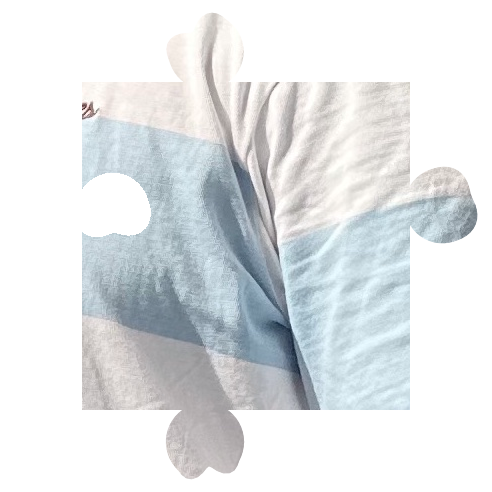

In [20]:
display(Image.fromarray(pg.pieces_arr[3,3]))

In [ ]:
# def create_tab(self, num_points, deform_angle, k=0.8):
    #     '''
    #     num_points: How many anchor points to put on the circle to create deformation
    #     deform_angle: number between [-180:180] indicating the location of the deformation
    #     k: factor by which to shrink the radius to create indent
    #     '''
    #     angle_step_size = 360 // num_points
    
    #     #Generate 50 evenly spaced theta values between 0-2pi (circle)
    #     theta = np.linspace(0, 2*np.pi)
    #     theta1 = deform_angle * np.pi / 180 #angle of deformation
    #     alpha = angle_step_size * np.pi / 180 #distance between points
    #     th = theta - theta1
    #     t = np.abs(np.where(th < np.pi, th, th - 2*np.pi)) / alpha
    #     r = np.where(t > 2, 1, k + (2*t**2-9*t+11)*t**2*(1-k)/4)
        
    #     fig, ax = plt.subplots()
    
    #     fig_size = self.segment // 100
    #     #print(fig_size)
    #     fig = plt.figure(frameon=False, figsize=(fig_size, fig_size))
    #     ax = plt.Axes(fig, [0.,0.,1.,1.])
    #     ax.set_axis_off()
    #     fig.add_axes(ax)
        
    #     #plt.plot(np.cos(theta), np.sin(theta), ':r')
    #     ax.plot(r * np.cos(theta), r * np.sin(theta), color='white')
    #     ax.axis('equal')
    #     plt.fill(r * np.cos(theta), r * np.sin(theta), color='white')
    #     fig.canvas.draw()
        
    #     buf = fig.canvas.buffer_rgba()
    #     ncols, nrows = fig.canvas.get_width_height()
    #     #print(ncols, nrows)
    #     tab = np.frombuffer(buf, dtype=np.uint8).reshape((nrows, ncols, 4))
    #     # for i in range(-5, 5):
    #     #     ax.plot(radius*np.cos(theta1 + i * alpha), radius*np.sin(theta1 + i * alpha), 'xk')
    
    #     #plt.show()
    #     return tab
    
    # def add_tab(self, location, tab=None, padding=None):
    #     '''location: number between 0 and 3 (inclusive) representing the side to place the tab on.
    #                 0
    #            -----------
    #           |           |
    #         1 |           | 3
    #           |           |
    #            -----------
    #                 2
    #         tab: for passing tabs already created in adjacent pieces
    #         padding: 
    #     '''
    #     if not tab:
    #         tab = create_tab(10, 100)
    #         match location:
    #             case 0:
    #                 bottom_padding = 5*self.segment-self.tab_shift
    #                 top_padding = self.piece_dim - (bottom_padding + self.segment)
    #                 right_padding = 2*self.segment
    #                 left_padding = self.piece_dim - (right_padding + self.segment)
    #             case 1:
    #                 right_padding = 5*self.segment-self.tab_shift
    #                 left_padding = self.piece_dim - (bottom_padding + self.segment)
    #                 top_padding = 2*self.segment
    #                 bottom_padding = self.piece_dim - (right_padding + self.segment)
    #             case 2:
    #                 top_padding = 5*self.segment-self.tab_shift
    #                 bottom_padding = self.piece_dim - (bottom_padding + self.segment)
    #                 left_padding = 2*self.segment
    #                 right_padding = self.piece_dim - (right_padding + self.segment)
    #             case 3:
    #                 left_padding = 5*self.segment-self.tab_shift
    #                 right_padding = self.piece_dim - (bottom_padding + self.segment)
    #                 bottom_padding = 2*self.segment
    #                 top_padding = self.piece_dim - (right_padding + self.segment)
    #             case _:
    #                 return f"Invalid tab location {location}. Please provide a number between 0-3"

    #             tab = np.pad(tab, ((top_padding,bottom_padding), (left_padding,right_padding), (0,0)), mode='constant')